In [1]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams.update({'font.size': 14})
%matplotlib notebook

<IPython.core.display.Javascript object>


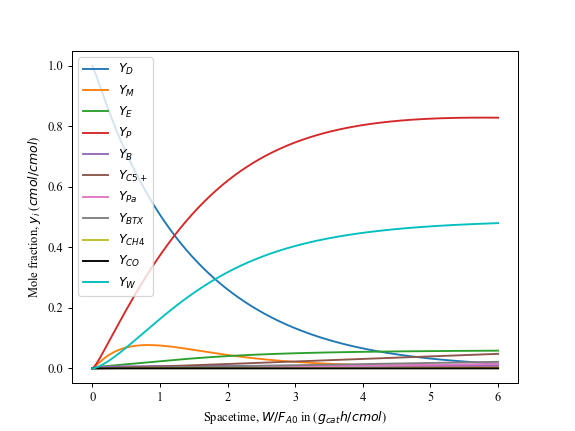

<IPython.core.display.Javascript object>


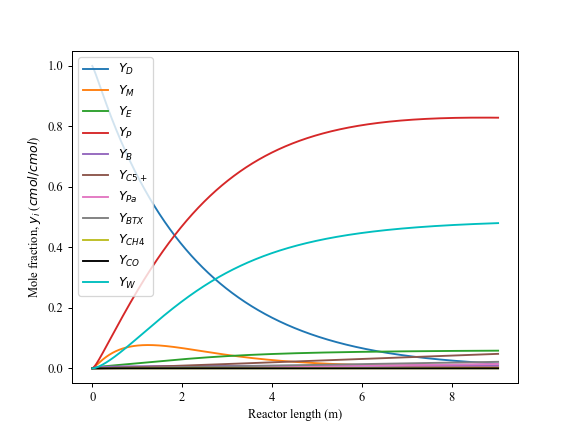

In [2]:
### Model parameters:
T0 = 623 #K
R = 8.206 # (m**3 atm)/ (K mol)
Ka = 1.27e1 #1/atm
#Scale up for reactor:
cmolfactor = 2 #cmol DME/mol DME
FA0 = 2247.84*cmolfactor*1000 #cmol DME feed (to reactor inlet)

####Kinetic parameters:
k_01 = 4.99e-2 
k_02 = 7.88e1 
k_03 = 2.42e-3 
k_04 = 2.48e-1 
k_05 = 2.54 
k_06 = 1.44e-1 
k_07 = 3.02e1 
k_08 = 2.63 
k_09 = 4.24e-1 
k_010 = 1.03 
k_011 = 1.16e-2 
k_012 = 3.10e-1 
k_013 = 5.63e-4 

f1 = 1.78e-1
f2 = 6.92e-1

k_010 = 1.03 
k_010_1 = k_010*f1
k_010_2 = k_010*f2

k_012 = 3.10e-1
k_012_1 = k_012*f1
k_012_2 = k_012*f2

E1 = 4.2e1
E2 = 1.2e1
E3 = 3.4e1
E4 = 1.7e1
E5 = 2.6e1
E6 = 9.8e1
E7 = 1.6e1
E8 = 1.7e1
E9 = 6.9e1
E10 = 2.1e1
E11 = 6e-1
E12 = 2.1e1
E13 = 3.4e1
###

### Non-adiabatic non isothermal heat transfer parameters:
rho_c = 1790 #kg/m**3
epsilon = 0.29 
rho_bed = rho_c*(1-epsilon) #kg/m**3
Tu = 300 #K cooling water constant temperature
U = 750 #(W/m**2 K) p656 Coulson @ boiling organics (paraffins) and cooling tower water
# heat transfer area (dependant on tube geometry used!)
a =  1990 #m**2  # solve until the temperature NEVER exceeds 573 K to prevent coking (no steam fed)  
#max a (at max pressure=20.1 atm) is 2375!
H1D =-40129 #kJ/kmolD
H2D =1980 #kJ/kmolD
H3M =-31152 #kJ/kmolM
H4D =-1886 #kJ/kmolD
H5D =-42734 #kJ/kmolD
H6D =-56355 #kJ/kmolD
H7M =-12972 #kJ/kmolM
H8M =-32454 #kJ/kmolM
H9M =-39265 #kJ/kmolM
H10_1E =-111938.03 #kJ/kmolE
H10P =-109404.8 #kJ/kmolP
H10_2B =-116607.14 #kJ/kmolB
H11_C5_plus =123615 #kJ/kmolC5_plus
H12_1E =-62495 #kJ/kmolE
H12P =-35298 #kJ/kmolP
H12_2B =-19818 #kJ/kmolB
H13D =2745 #kJ/kmolD

CpD =102.8 #kJ/kmolK
CpM =50.94 #kJ/kmolK
CpE =68.73 #kJ/kmolK
CpP =104 #kJ/kmolK
CpB =142.56 #kJ/kmolK
Cp_C5_plus =202.25 #kJ/kmolK
CpPa =125.02 #kJ/kmolK
CpBTX =186.6 #kJ/kmolK
CpCH4 =65.4 #kJ/kmolK
CpCO =30.27 #kJ/kmolK
CpW = 36.11 #kJ/kmolK
###

###Ergun equation parameters:
Catalyst = 25892.3112151 #kg chosen from previous model
L_D_ratio = 5 #suggested is to use 3 < L/D < 8
D = (Catalyst/(rho_bed*np.pi/4*L_D_ratio))**1/3
L = L_D_ratio*D
Ac = ((np.pi)/4)*D**2
Dp = 4.5/1000 #m
D_tube = 0.04 #D = 0.040822697 for exact number of tubes
N_tubes = D**2/D_tube**2 
#Mole masses:
MM_D = 46.07/2 #kg/kmolc #CMOLES
MM_M = 32/1
MM_E = 28/2
MM_P = 42/3
MM_B = 56/4
MM_C5_plus = 72/5 #lumped here as C5H12
MM_Pa = 44/3 #lumped here as C3H8
MM_BTX =92/7 #lumped here as toluene (C7H8)
MM_CH4 = 16/1
MM_CO = 28/1
MM_W = 18

rho_in = 12.8969 #kg/m^3 @Tin=473K and Pin=16.91atm   otherwise: rho_in = Pin*MM_D/(R*Tin)
G = 103556/Ac/3600 #kg/s m**2 #with no hold up or change in area (remember: G=f(D))
###

def ri(x):
    pD,pM,pE,pP,pB,pC5_plus,pPa,pBTX,pCH4,pCO,pW, T, P = x
    
    K2 = np.exp(-(-9.76 + 3200/T + 1.07*np.log(T) -6.6e-4*T + 4.9e-8*T**2 + 6500/T**2)) #'dimensionless'
   
    θ = 1/(1 + Ka*(pM + pW)) #dimensionless

    k1 = k_01*np.exp((-E1/R)*(1/T - 1/T0)) #molc/(gcat h atm)#I think this should be: molc/(gcat h atm)
    k2 = k_02*np.exp((-E2/R)*(1/T - 1/T0)) #molc/(gcat h atm**2)#should be: molc/(gcat h atm**2)
    k3 = k_03*np.exp((-E3/R)*(1/T - 1/T0)) #molc/(gcat h atm)
    k4 = k_04*np.exp((-E4/R)*(1/T - 1/T0)) #molc/(gcat h atm**2)
    k5 = k_05*np.exp((-E5/R)*(1/T - 1/T0)) #molc/(gcat h atm**2)
    k6 = k_06*np.exp((-E6/R)*(1/T - 1/T0)) #molc/(gcat h atm**2)
    k7 = k_07*np.exp((-E7/R)*(1/T - 1/T0)) #molc/(gcat h atm**2)
    k8 = k_08*np.exp((-E8/R)*(1/T - 1/T0)) #molc/(gcat h atm**2)
    k9 = k_09*np.exp((-E9/R)*(1/T - 1/T0)) #molc/(gcat h atm**2)
    k10 = k_010*np.exp((-E10/R)*(1/T - 1/T0)) #molc/(gcat h atm)
    k10_1 = k_010_1*np.exp((-E10/R)*(1/T - 1/T0)) #molc/(gcat h atm)
    k10_2 = k_010_2*np.exp((-E10/R)*(1/T - 1/T0)) #molc/(gcat h atm)
    k11 = k_011*np.exp((-E11/R)*(1/T - 1/T0)) #molc/(gcat h atm)
    k12 = k_012*np.exp((-E12/R)*(1/T - 1/T0)) #molc/(gcat h atm)
    k12_1 = k_012_1*np.exp((-E12/R)*(1/T - 1/T0)) #molc/(gcat h atm)
    k12_2 = k_012_2*np.exp((-E12/R)*(1/T - 1/T0)) #molc/(gcat h atm)
    k13 = k_013*np.exp((-E13/R)*(1/T - 1/T0)) #molc/(gcat h atm)


    r1 = k1*pD*θ #because units were fixed this is: molc/(gcat h)
    r2 = k2*(pD*pW - (pM**2)/K2)*θ #reversible reaction
    r3 = k3*pM*θ
    r4 = k4*pD*pE*θ
    r5 = k5*pD*pP*θ
    r6 = k6*pD*pB*θ
    r7 = k7*pM*pE*θ
    r8 = k8*pM*pP*θ
    r9 = k9*pM*pB*θ
    r10 = k10*pP*θ
    r10_1 = k10_1*pE*θ
    r10_2 = k10_2*pB*θ
    r11 = k11*pC5_plus*θ
    r12 = k12*pP*θ
    r12_1 = k12_1*pE*θ
    r12_2 = k12_2*pB*θ
    r13 = k13*pD*θ
    #       1    2     3    4    5    6    7    8    9   10   10_1   10_2     11   12         12_1       12_2   13
    rD = -6*r1-2*r2     -2*r4-2*r5-2*r6                                                                     -6*r13
    rM =       2*r2-3*r3                 -r7  -r8  -r9 #molMc/ (gcat h)
    rE = 2*r1      + r3 +2*r4           + r7               - r10_1                       -2.5*r12_1 #molEc/ (gcat h)
    rP = 2*r1      + r3      +2*r5           + r8     -r10                       -2.5*r12 #molPc/ (gcat h)
    rB = 2*r1      + r3           +2*r6           + r9            - r10_2                          -2.5*r12_2 
    rC5_plus =                                          r10 +r10_1 +r10_2-2.5*r11 #molC5_plusc/ (gcat h)
    rPa =                                                                     r11 +   r12 +   r12_1+    r12_2 
    rBTX =                                                                1.5*r11+1.5*r12+1.5*r12_1+1.5*r12_2 
    rCH4 =                                                                                                   4*r13 
    rCO =                                                                                                    2*r13 
    rW =   r1 - r2 + r3 + r4 +  r5 + r6 + r7 + r8 + r9  #molWc/ (gcat h)
    
    return [[rD,rM,rE,rP,rB,rC5_plus,rPa,rBTX,rCH4,rCO,rW, T, P],
            [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r10_1,r10_2,r11,r12,r12_1,r12_2,r13]]

def cmolbalance(variables, catalyst):
    rD,rM,rE,rP,rB,rC5_plus,rPa,rBTX,rCH4,rCO,rW, T, P = ri(variables)[0]
    r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r10_1,r10_2,r11,r12,r12_1,r12_2,r13 = ri(variables)[1]
    FD, FM, FE, FP, FB, F_C5_plus, FPa, FBTX, FCH4, FCO, FW, placehold1, placehold2 = variables*FA0/Pin
    #Energy balance:
    #dTdW_FA0 = T
    dTdW_FA0 = (FA0*((U*a/rho_bed)*(Tu - T) +
             
             ( 6*r1*-H1D
             + 2*r2*-H2D
             + 3*r3*-H3M
             + 2*r4*-H4D
             + 2*r5*-H5D
             + 2*r6*-H6D
             + r7*-H7M
             + r8*-H8M
             + r9*-H9M
             + r10*-H10P
             + r10_1*-H10_1E
             + r10_2*-H10_2B
             + 2.5*r11*-H11_C5_plus
             + 2.5*r12*-H12P
             + 2.5*r12_1*-H12_1E
             + 2.5*r12_2*-H12_2B
             + 6*r13*-H13D)) /
              
              (FD*CpD 
             + FM*CpM 
             + FE*CpE 
             + FP*CpP 
             + FB*CpB 
             + F_C5_plus*Cp_C5_plus 
             + FPa*CpPa
             + FBTX*CpBTX  
             + FCH4*CpCH4
             + FCO*CpCO 
             + FW*CpW))
    
    Ft = FD + FM + FE + FP + FB + F_C5_plus + FPa + FBTX + FCH4 + FCO + FW
    
    #Pressure drop (Ergun equation for turbulent gasses):
    #G = (MM_D*FD + MM_M*FM + MM_E*FE + MM_P*FP + MM_B*FB + MM_C5_plus*F_C5_plus + MM_Pa*FPa 
    #     + MM_BTX*FBTX + MM_CH4*FCH4 + MM_CO*FCO + MM_W*FW)/Ac #(kg/s m**2)
    
    K = (1.75*G**2)*(1-epsilon)/(rho_in*Dp*epsilon**3)
    dPdW_FA0 = -((FA0*K)/(Ac*rho_bed))*(Pin/P)*(Ft/FA0)     #convert from 'Pa' to 'atm' later!
    
    #Mole balances:
    dyDdW_FA0 = rD #molDc/ (gcat h)
    dyMdW_FA0 = rM
    dyEdW_FA0 = rE
    dyPdW_FA0 = rP
    dyBdW_FA0 = rB
    dyC5_plusdW_FA0 = rC5_plus
    dyPadW_FA0 = rPa
    dyBTXdW_FA0 = rBTX
    dyCH4dW_FA0 = rCH4
    dyCOdW_FA0 = rCO
    dyWdW_FA0 = rW
    return [dyDdW_FA0,dyMdW_FA0,dyEdW_FA0,dyPdW_FA0,dyBdW_FA0,dyC5_plusdW_FA0,
            dyPadW_FA0,dyBTXdW_FA0,dyCH4dW_FA0,dyCOdW_FA0,dyWdW_FA0, dTdW_FA0, dPdW_FA0]

Pin = 16.91 #atm  #use P=16.91 atm for max catalyst(WHSV) AND check max temperature> change 'a'
Tin= 473 #K or 200C #also MAX P = 20.1 atm for WHSV of 4 then see 'a' for increase HX
PA0 = Pin
variables = [PA0,0,0,0,0,0,0,0,0,0,0, Tin, Pin*101325]
spacetime = np.linspace(0,6,10000) # gcat h/ cmol
solve  = odeint(cmolbalance, variables, spacetime)
#Ptotal = Pin #atm not applicable anymore
#moleflow = solve*FA0/cmolfactor/Ptotal/1000 #kmol i/h #N/A
catalyst_scaled = spacetime*FA0/1000 # kg
Volume = catalyst_scaled/rho_bed
Length = catalyst_scaled/(rho_bed*Ac)

plt.figure(1)
plt.plot(spacetime, solve[:,0]/Pin, label='$Y_D$')
plt.plot(spacetime, solve[:,1]/Pin, label='$Y_M$')
plt.plot(spacetime, solve[:,2]/Pin, label='$Y_E$')
plt.plot(spacetime, solve[:,3]/Pin, label='$Y_P$')
plt.plot(spacetime, solve[:,4]/Pin, label='$Y_B$')
plt.plot(spacetime, solve[:,5]/Pin, label='$Y_{C5+}$')
plt.plot(spacetime, solve[:,6]/Pin, label='$Y_{Pa}$')
plt.plot(spacetime, solve[:,7]/Pin, label='$Y_{BTX}$')
plt.plot(spacetime, solve[:,8]/Pin, label='$Y_{CH4}$')
plt.plot(spacetime, solve[:,9]/Pin, label='$Y_{CO}$', color='black')
plt.plot(spacetime, solve[:,10]/Pin, label='$Y_W$', color='c')
plt.xlabel('Spacetime, $W/F_{A0}$ in ($g_{cat} h/ cmol$)')
plt.ylabel('Mole fraction, $y_i$ ($cmol/cmol$)')
plt.legend(loc='best')
plt.show()
plt.savefig("figure1a_Model3.png")

plt.figure(2)
plt.plot(Length, solve[:,0]/Pin, label='$Y_D$')
plt.plot(Length, solve[:,1]/Pin, label='$Y_M$')
plt.plot(Length, solve[:,2]/Pin, label='$Y_E$')
plt.plot(Length, solve[:,3]/Pin, label='$Y_P$')
plt.plot(Length, solve[:,4]/Pin, label='$Y_B$')
plt.plot(Length, solve[:,5]/Pin, label='$Y_{C5+}$')
plt.plot(Length, solve[:,6]/Pin, label='$Y_{Pa}$')
plt.plot(Length, solve[:,7]/Pin, label='$Y_{BTX}$')
plt.plot(Length, solve[:,8]/Pin, label='$Y_{CH4}$')
plt.plot(Length, solve[:,9]/Pin, label='$Y_{CO}$', color='black')
plt.plot(Length, solve[:,10]/Pin, label='$Y_W$', color='c')
plt.xlabel('Reactor length (m)')
plt.ylabel('Mole fraction, $y_i$ ($cmol/cmol$)')
plt.legend(loc='best')
plt.show()
plt.savefig("figure1b_Model3.png")



<IPython.core.display.Javascript object>


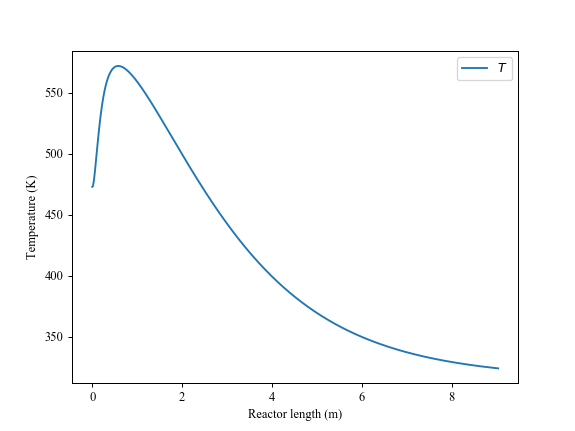

<IPython.core.display.Javascript object>


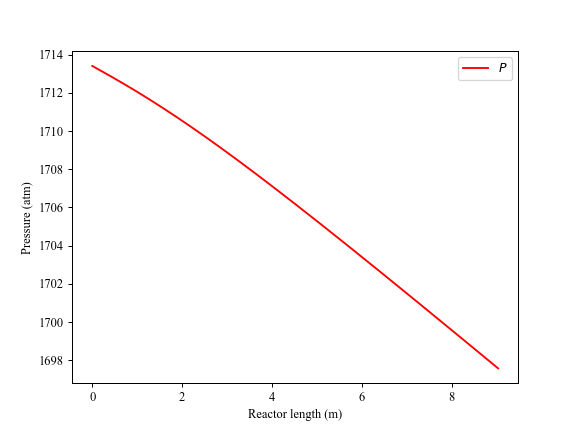

Maximum temperature = 572.094394116 K
Total catalyst used= 25892.3112151 kg
Volume of packed bed reactor = 20.373208919 m^3
Length = 8.646658416254905 m
Diameter = 1.729331683250981 m
Volume calculated = 20.3092918516059
Pressure drop = 1.83020976804 kPa/m
Number of tubes calculated = 1831.449338610804 with Dtube = 0.04 m
Number of tubes estimated = 1869.1175441847945 with Dtube = 0.04 m


In [3]:
plt.figure(3)
plt.plot(Length, solve[:,11], label='$T$')
plt.xlabel('Reactor length (m)')
plt.ylabel('Temperature (K)')
plt.legend(loc='best')
plt.show()
plt.savefig("figure2_Model3.png")

plt.figure(4)
plt.plot(Length, solve[:,12]/1000, label='$P$', color='red')
plt.xlabel('Reactor length (m)')
plt.ylabel('Pressure (atm)')
plt.legend(loc='best')
plt.show()
plt.savefig("figure3_Model3.png")

print ('Maximum temperature =', max(solve[:,11]), 'K')
print ('Total catalyst used=', catalyst_scaled[solve[:,3].argmax()], 'kg')
print ('Volume of packed bed reactor =', Volume[solve[:,3].argmax()], 'm^3')
print ('Length =', L, 'm')
print ('Diameter =', D, 'm')
print ('Volume calculated =', np.pi/4*D**2*L)
print ('Pressure drop =', (Pin*101.325 - solve[-1,12]/1000)/L,'kPa/m')
print ('Number of tubes calculated =', a/(L*D_tube*np.pi), 'with Dtube =', D_tube, 'm')
print ('Number of tubes estimated =', N_tubes, 'with Dtube =', D_tube, 'm')

In [4]:
d=solve[-1,0]/Pin
m=solve[-1,1]/Pin
e=solve[-1,2]/Pin
p=solve[-1,3]/Pin
b=solve[-1,4]/Pin
c5=solve[-1,5]/Pin
pa=solve[-1,6]/Pin
btx=solve[-1,7]/Pin
ch4=solve[-1,8]/Pin
co=solve[-1,9]/Pin
w=solve[-1,10]/Pin

In [5]:
d*100

1.5683069786079837

In [6]:
m*100

0.40020098080048044

In [7]:
e*100

5.8498666605186145

In [8]:
p*100

82.890138068315835

In [9]:
b*100

0.84985073870119787

In [10]:
c5*100

4.7978801576547427

In [11]:
pa*100

1.4470868881710774

In [12]:
btx*100

2.1706303322566156

In [13]:
ch4*100

0.017359463315625483

In [14]:
co*100

0.0086797316578127413

In [15]:
w*100

48.031775290369445